
### 1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>. You have to use data.csv file for this assignment
### 2. Code the model to classify data like below image. You can use any number of units in your Dense layers.

<img src='https://i.imgur.com/33ptOFy.png'>



In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from tensorflow.keras import layers
from tensorflow import keras
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

from sklearn.metrics import roc_auc_score, f1_score
import numpy as np # importing numpy for numerical computation
from itertools import combinations
import os,datetime

print(tf.__version__)

2.9.1


ref: https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

In [2]:
data  = pd.read_csv("data.csv")

print(data.columns)
print("**"*15)
print(data.shape)
print("**"*15)
print(data.head(5))

Index(['f1', 'f2', 'label'], dtype='object')
******************************
(20000, 3)
******************************
         f1        f2  label
0  0.450564  1.074305    0.0
1  0.085632  0.967682    0.0
2  0.117326  0.971521    1.0
3  0.982179 -0.380408    0.0
4 -0.720352  0.955850    0.0


In [3]:
data['f1'].describe()

count    20000.000000
mean         0.000630
std          0.671165
min         -1.649781
25%         -0.589878
50%          0.001795
75%          0.586631
max          1.629722
Name: f1, dtype: float64

In [4]:
data['f2'].describe()

count    20000.000000
mean        -0.000745
std          0.674704
min         -1.600645
25%         -0.596424
50%         -0.003113
75%          0.597803
max          1.584291
Name: f2, dtype: float64

In [5]:
data['label'].describe()

count    20000.000000
mean         0.500000
std          0.500013
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [6]:
data_labels = data['label'].values
data_features = data.drop(['label'],axis=1)

X_train, X_test, y_train, y_test = train_test_split( data_features, data_labels, test_size=0.25, random_state=42)

print('After spliting the data the size of train and test becomes:')
print('Training data',X_train.shape, y_train.shape)
print('Testing data', X_test.shape ,y_test.shape )

print('*'*20)
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

After spliting the data the size of train and test becomes:
Training data (15000, 2) (15000,)
Testing data (5000, 2) (5000,)
********************
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
#ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
normalize = tf.keras.layers.Normalization(axis=-1)
normalize.adapt(X_train)
normalize(X_train)

<tf.Tensor: shape=(15000, 2), dtype=float32, numpy=
array([[ 1.413,  0.568],
       [-1.14 , -0.264],
       [ 0.762, -0.677],
       ...,
       [-0.82 ,  0.702],
       [ 1.604, -0.43 ],
       [-0.612, -1.184]], dtype=float32)>

# <font color='red'> <b>3. Writing Callbacks </b> </font>
## You have to implement the following callbacks
-  Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.Do not use tf.keras.metrics for calculating AUC and F1 score.

- Save your model at every epoch if your validation accuracy is improved from previous epoch. 

- You have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay your learning rate by 5%.
        
- If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 

- You have to stop the training if your validation accuracy is not increased in last 2 epochs.

- Use tensorboard for every model and analyse your scalar plots and histograms. (you need to upload the screenshots and write the observations for each model for evaluation)



<b> Tensorflow callbacks are functions or block of code which are executed during a specific instant</b>
<pre> 1. Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.
2. Callbacks can help you prevent overfitting, visualize training progress, debug your code, save checkpoints, generate logs, create a TensorBoard, etc. </pre>
references : __[here](https://blog.paperspace.com/tensorflow-callbacks/)__,
__[here1](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)__,
__[here3](https://towardsdatascience.com/the-million-dollar-question-when-to-stop-training-deep-learning-models-fa9b488ac04d)__
        
       





In [9]:
#Write your own callback function, that has to print the micro F1 score and AUC score after each epoch
#Do not use tf.keras.metrics for calculating AUC and F1 score.

#ref:https://www.tensorflow.org/guide/keras/custom_callback

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.validation_data=(X_test,y_test)
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []   
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        val_f1 = f1_score(val_targ, val_predict.round(),average='micro')
        roc_val= roc_auc_score(val_targ, val_predict)
        self.val_f1s.append(val_f1)  
        print("-f1 score :",val_f1,"-ROCValue :", roc_val)
        
custom_callback =  CustomCallback()       

In [10]:
#- Save your model at every epoch if your validation accuracy is improved from previous epoch. 
# ref: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
                                                monitor='val_accuracy',  
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='auto')


In [11]:
#- You have to decay learning based on below conditions 
#ref: https://stackoverflow.com/questions/61981929/how-to-change-the-learning-rate-based-on-the-previous-epoch-accuracy-using-keras

#*******************************************************************************************************************************
#Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               #learning rate by 10%. 

# If you want to change the learning rate in relation to some metric, use ReduceLROnPlateau

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.90,
                                                 patience=1,
                                                 verbose=1
                                                )

#**************************************************************************************************************************************

#Cond2: For every 3rd epoch, decay your learning rate by 5%.

#If you want to change the learning rate in relation to number of epochs, use LearningRateScheduler:
def scheduler(epoch, lr):
    if ((epoch+1) % 3) == 0 :
        lr = lr*0.95
    return lr
   
    
learning_rate_schedular  = tf.keras.callbacks.LearningRateScheduler(scheduler,
                                                                    verbose=1
                                                                   )          

In [12]:
#- If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 
# ref:https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TerminateOnNaN

#writing callback when loss becomes nan
class TerminateNaNLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True
                
terminate_nan_loss = TerminateNaNLoss()  

#writing callback when weights becomes nan
class TerminateNaNweights(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights = self.model.get_weights()
        if model_weights is not None:
            if np.any([np.any(np.isnan(x)) for x in model_weights]):
                print("Invalid weights and terminate at epoch {}".format(epoch))
                self.model.stop_training = True
                
terminate_nan_weights = TerminateNaNweights()



In [13]:
# - You have to stop the training if your validation accuracy is not increased in last 2 epochs.
#ref: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=2,
                                                  verbose=1
                                                 )


In [14]:
%load_ext tensorboard


<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

<b> Tanh is similar to sigmoid function but here the output range is [-1,1]</b>
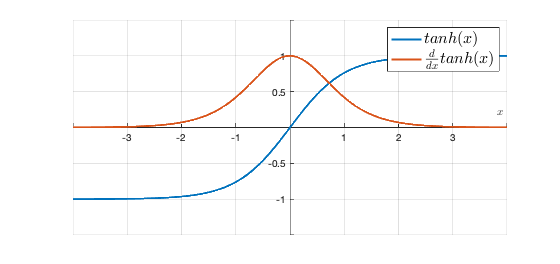

<b> Momentum is an extension to gradient descent optimization algorithm that allows the search to build inertia in a direction of search space and overcome oscillations of noisy gradients and coast across flat sposts of search space </b>
<div>
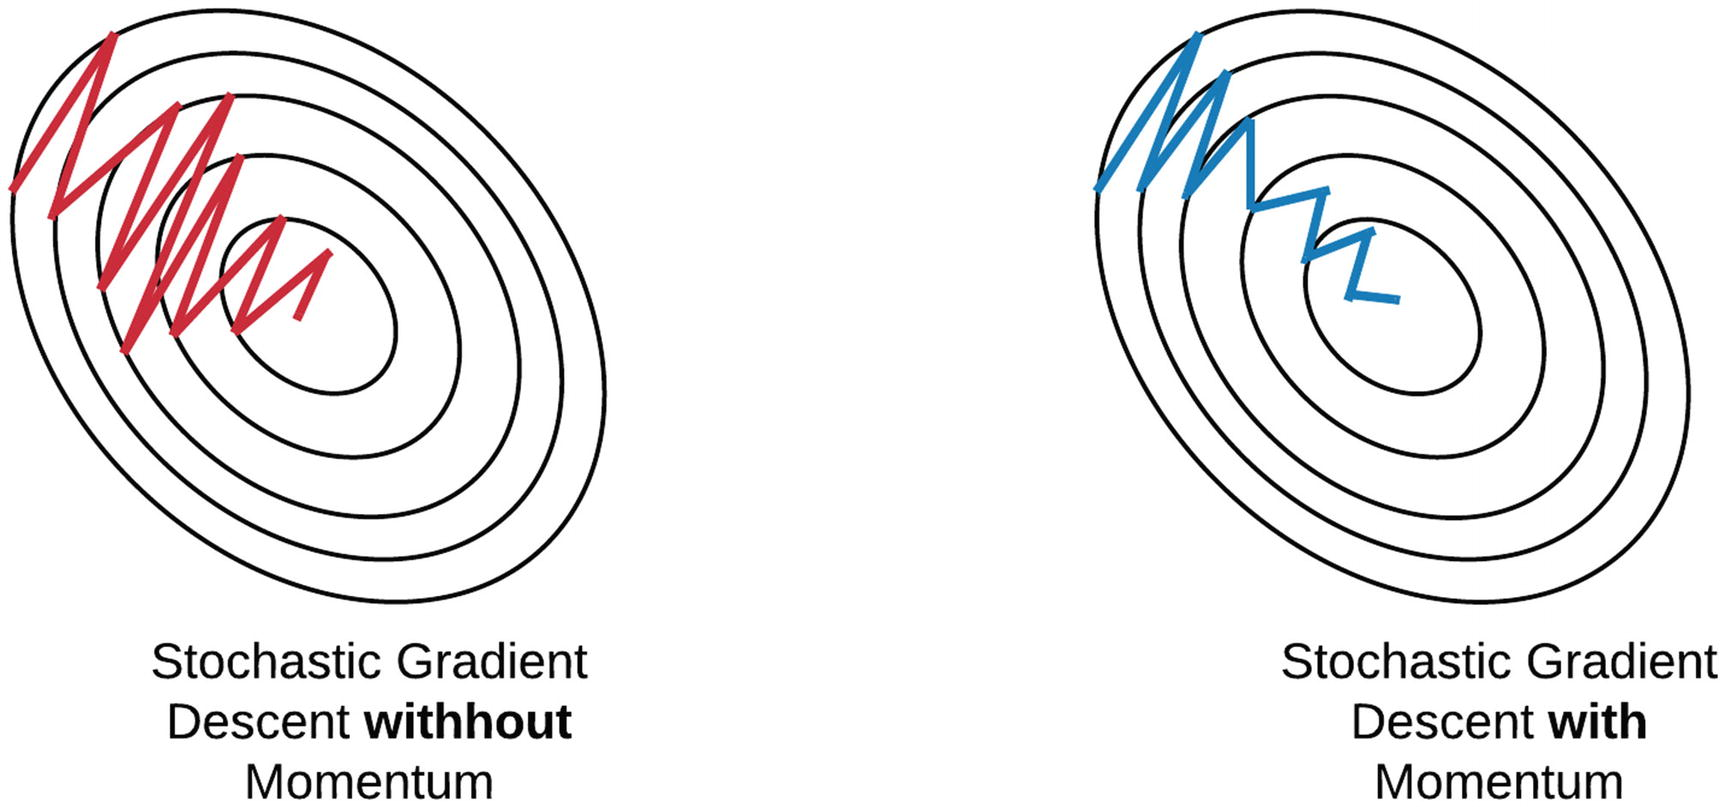
</div>

In [15]:
def model_1():
    normalize
    initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)

    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(2,)))
    model.add(layers.Dense(128, activation='tanh',kernel_initializer=initializer))
    model.add(layers.Dense(64, activation="tanh",kernel_initializer=initializer))
    model.add(layers.Dense(64, activation="tanh",kernel_initializer=initializer))
    model.add(layers.Dense(32, activation="tanh",kernel_initializer=initializer))
    model.add(layers.Dense(16, activation="tanh",kernel_initializer=initializer))
    model.add(layers.Dense(1, activation="sigmoid",kernel_initializer=initializer))
    
    return model
              

In [16]:
tanh_model = model_1()
tanh_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 15,425
Trainable params: 15,425
Non-traina

In [30]:
def train_model():
    model = model_1()
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = tf.keras.metrics.Accuracy()
                  )
    


    log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)


    model.fit(x=X_train,
              y=y_train,
              validation_data=(X_test, y_test),
              epochs=15,
              verbose=1,
              callbacks=[custom_callback,
                          learning_rate_schedular,
                         checkpoint,
                         reduce_lr,
                         terminate_nan_loss,
                         terminate_nan_weights,
                         early_stopping,
                         tensorboard_callback])

train_model()


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/15
157/157 [==============================] - 1s 2ms/steposs: 1.0401 - accurac
-f1 score : 0.4906 -ROCValue : 0.49062366245184824

Epoch 1: val_accuracy did not improve from 0.00000
469/469 [==============================] - 24s 9ms/step - loss: 1.0314 - accuracy: 0.0000e+00 - val_loss: 0.6936 - val_accuracy: 0.0000e+00 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/15
157/157 [==============================] - 0s 2ms/steposs: 0.6936 - accuracy: 
-f1 score : 0.5094 -ROCValue : 0.5093763375481517

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.
469/469 [==============================] - 3s 6ms/step - loss: 0.6936 - accuracy: 0.0000e+00 - val_loss: 0.6930 - val_accuracy: 0.0000e+00 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.008549999631941318.


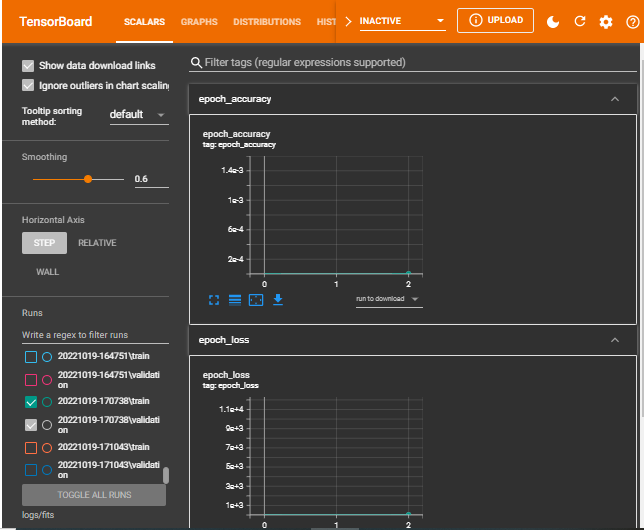 

<div>
<img src="attachment:image-2.png" width="300"/>
</div>

<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

<div>
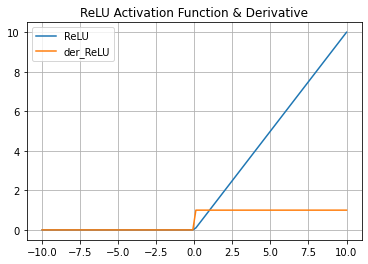
</div>


<div>
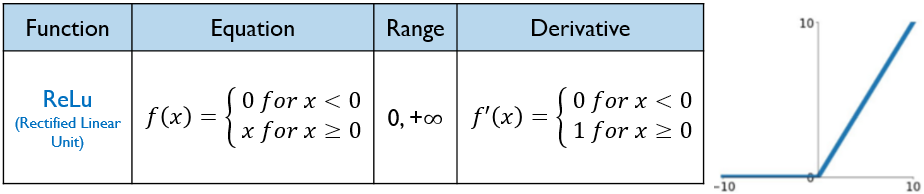
</div>

In [19]:
def model_2():
    initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(2,)))
    model.add(layers.Dense(128, activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(128, activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(64, activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(64, activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(32, activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    return model
              

In [20]:
relu_model = model_2()
relu_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               384       
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,425
Trainable params: 31,425
Non-trai

In [31]:
def train_model_relu():
    model = model_2()
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.95),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = tf.keras.metrics.Accuracy()
                  )
    log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)


    model.fit(x=X_train,
              y=y_train,
              validation_data=(X_test, y_test),
              epochs=15,
              verbose=1,
              callbacks=[custom_callback,
                         checkpoint,
                         reduce_lr,
                         learning_rate_schedular,
                         terminate_nan_loss,
                         terminate_nan_weights,
                         early_stopping,
                         tensorboard_callback])

train_model_relu()


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/15
157/157 [==============================] - 1s 3ms/steposs: 16638.3828 - a
-f1 score : 0.497 -ROCValue : 0.5

Epoch 1: val_accuracy did not improve from 0.00000
469/469 [==============================] - 6s 8ms/step - loss: 16398.7969 - accuracy: 0.0021 - val_loss: 0.6991 - val_accuracy: 0.0000e+00 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/15
157/157 [==============================] - 0s 2ms/steposs: 0.6971 - accura
-f1 score : 0.497 -ROCValue : 0.5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.09000000134110452.
469/469 [==============================] - 3s 6ms/step - loss: 0.6970 - accuracy: 0.0000e+00 - val_loss: 0.6954 - val_accuracy: 0.0000e+00 - lr: 0.0900

Epoch 3: LearningRateScheduler setting learning rate to 0.08550000339746475.
Epoch 3/15
157/157 [========================

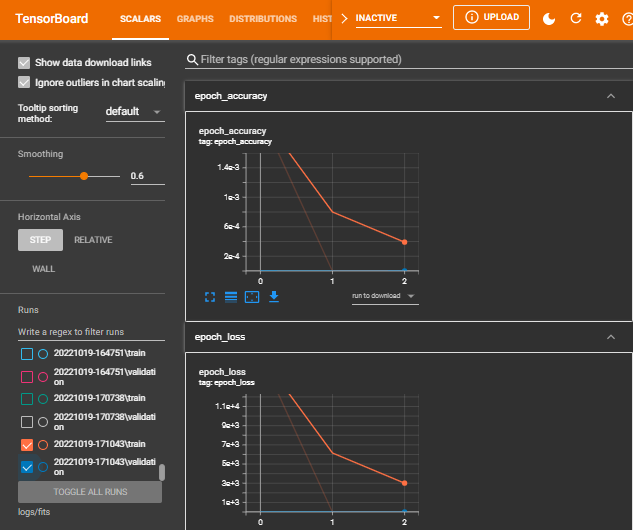

<pre>
<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [23]:
def model_3():
    normalize
    initializer = tf.keras.initializers.HeUniform()
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(2,)))
    model.add(layers.Dense(128, activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(128, activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(64, activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(64 ,activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(32 ,activation="relu",kernel_initializer=initializer))
    model.add(layers.Dense(1, activation="sigmoid",kernel_initializer=initializer))
    
    return model
              

In [24]:
relu_model_1 = model_3()
relu_model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               384       
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,425
Trainable params: 31,425
Non-trai

In [33]:
def train_model_relu_1():
    model = model_3()
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.95),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = tf.keras.metrics.Accuracy()
                  )
    log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

    model.fit(x=X_train,
              y=y_train,
              validation_data=(X_test, y_test),
              epochs=15,
              verbose=1,
              callbacks=[custom_callback,
                         checkpoint,
                         reduce_lr,
                         learning_rate_schedular,
                         terminate_nan_loss,
                         terminate_nan_weights,
                         early_stopping,
                         tensorboard_callback])

train_model_relu_1()


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/15
157/157 [==============================] - 1s 3ms/steposs: 0.6756 - acc
-f1 score : 0.5622 -ROCValue : 0.5645111224004065

Epoch 1: val_accuracy did not improve from 0.00000
469/469 [==============================] - 5s 9ms/step - loss: 0.6754 - accuracy: 0.0000e+00 - val_loss: 0.6694 - val_accuracy: 0.0000e+00 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/15
157/157 [==============================] - 0s 2ms/steposs: 0.6334 - accuracy
-f1 score : 0.6188 -ROCValue : 0.6171878187614754

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.09000000134110452.
469/469 [==============================] - 3s 7ms/step - loss: 0.6338 - accuracy: 0.0000e+00 - val_loss: 0.6863 - val_accuracy: 0.0000e+00 - lr: 0.0900

Epoch 3: LearningRateScheduler setting learning rate to 0.08550000339746475.
Epoch 3/15
1

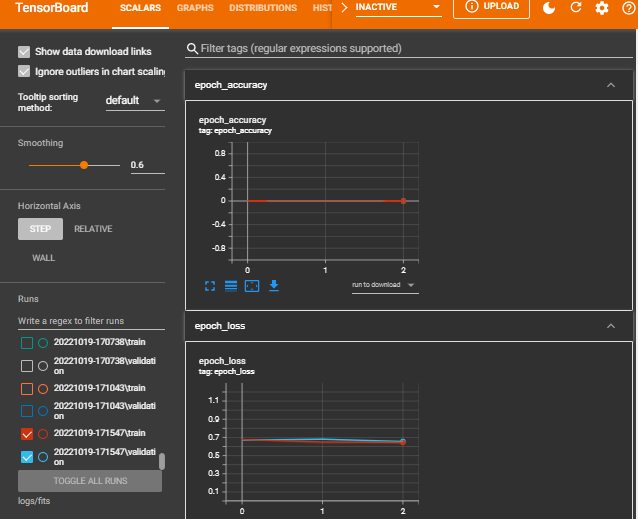




<pre>
<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

In [27]:
def model_4():
    normalize
    initializer = tf.keras.initializers.GlorotNormal()
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(2,)))
    model.add(layers.Dense(32, activation="LeakyReLU",kernel_initializer=initializer))
    model.add(layers.Dense(16, activation="LeakyReLU",kernel_initializer=initializer))
    model.add(layers.Dense(16, activation="LeakyReLU",kernel_initializer=initializer))
    model.add(layers.Dense(8 ,activation="LeakyReLU",kernel_initializer=initializer))
    model.add(layers.Dense(8 ,activation="LeakyReLU",kernel_initializer=initializer))
    model.add(layers.Dense(1, activation="sigmoid",kernel_initializer=initializer))
    
    return model
              

In [28]:
custom_model = model_4()
custom_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,name='adam'),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = tf.keras.metrics.Accuracy()
                  )
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

custom_model.fit(x=X_train,
               y=y_train,
              validation_data=(X_test, y_test),
              epochs=15,
              verbose=1,
              callbacks=[custom_callback,
                         checkpoint,
                         reduce_lr,
                         learning_rate_schedular,
                         terminate_nan_loss,
                         terminate_nan_weights,
                         early_stopping,
                         tensorboard_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/15
157/157 [==============================] - 0s 2ms/steposs: 0.6710 - accuracy: 0
-f1 score : 0.6358 -ROCValue : 0.634801652859503

Epoch 1: val_accuracy did not improve from 0.00000
469/469 [==============================] - 5s 7ms/step - loss: 0.6692 - accuracy: 0.0000e+00 - val_loss: 0.6403 - val_accuracy: 0.0000e+00 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/15
157/157 [==============================] - 0s 2ms/steposs: 0.6168 - accuracy: 0.
-f1 score : 0.658 -ROCValue : 0.658573308639111

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.
469/469 [==============================] - 3s 6ms/step - loss: 0.6164 - accuracy: 0.0000e+00 - val_loss: 0.6234 - val_accuracy: 0.0000e+00 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008549999631941318.

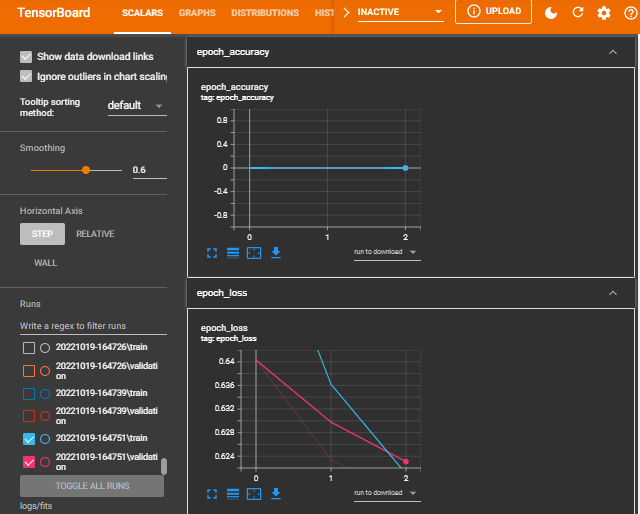

1. We define and use a callback when we want to automate some tasks after every training/epoch that helps us to have controls over the training process.
>This includes stopping training when you reach a certain accuracy/loss score, saving your model as a checkpoint after each successful epoch, adjusting the learning rates over time ,and more.
2. <b> Early stopping : </b> 
> helps us to terimate the process early to avoid overfitting the model
3. <b> Model checkpoint : </b> 
> saves mode after every epoch/any other metric defines (here we save only model weights but not the architecture)
4. <b> Learning Rate Scheduler : </b> 
> it adjusts the learning rate over time using a schedule that we already write beforehand. This function returns the desired learning rate (output) based on the current epoch (epoch index as input).
5. <b> ReduceLR on Plateau : </b> 
>it changes learning rate when metrics have stopped improving
6. <b> TensorBoard : </b> 
>writes a log for TensorBoard, which is TensorFlow’s excellent visualization tool.
7. <b> TerminateOnNaN : </b> 
>terminates process when metrics become NaN. Here we implemented custom Callback for NaN which terminates process when weights/loss becomes NaN(NotANumber)
-
-
>we can conculde that Callbacks give control over our model by monitoring and improving the model